## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv` 

In [1]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

!pip3 install gdown


import gdown
# train
url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

output = 'train.csv'
gdown.download(url, output, quiet=True)

# test
url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

output = 'test.csv'
gdown.download(url, output, quiet=True)

# user features
url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
output = 'users.csv'
gdown.download(url, output, quiet=True, fuzzy=True)

# item features
url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
output = 'items.csv'
gdown.download(url, output, quiet=True)

'items.csv'

In [44]:
import numpy as np
import pandas as pd

In [276]:
users = pd.read_csv('users.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')

In [277]:
users.head(2)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0


In [278]:
items.head(2)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."


In [279]:
train.head(2)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1


In [280]:
test.head(2)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,718866,6382,2021-08-13,10309,19.0,0
1,147119,13865,2021-08-13,1666,26.0,0


In [281]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


In [288]:
users = users.fillna("unknown")

In [290]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [292]:
def fill_null_val(row):
    if pd.isna(row['age_rating']):
        if 'для детей' in row['genres']:
            row['age_rating'] = 6.0
        else:
            row['age_rating'] = 16.0
    
    if pd.isna(row['for_kids']):
        if row['age_rating'] < 12:
            row['for_kids'] = 1.0
        else:
            row['for_kids'] = 0.0
    
    if pd.isna(row['title_orig']):
        row['title_orig'] = row['title']
    
    return row

In [294]:
items = items.apply(fill_null_val, axis=1)
items['countries'] = items['countries'].fillna("общая")
items['release_year'] = items['release_year'].fillna(2020.0)
items['studios'] = items['studios'].fillna("unknown")
items['actors'] = items['actors'].fillna("unknown")
items['directors'] = items['directors'].fillna("unknown")
items['description'] = items['description'].fillna("unknown")
items['keywords'] = items['keywords'].fillna("unknown")

In [296]:
train.user_id.nunique(), train.item_id.nunique()

(880421, 15418)

In [298]:
train['last_watch_dt'] = (pd.to_datetime(train['last_watch_dt']) - pd.to_datetime(train['last_watch_dt']).min())
train['last_watch_dt'] = train.last_watch_dt.apply(lambda x: int(str(x).split()[0]))

<Axes: >

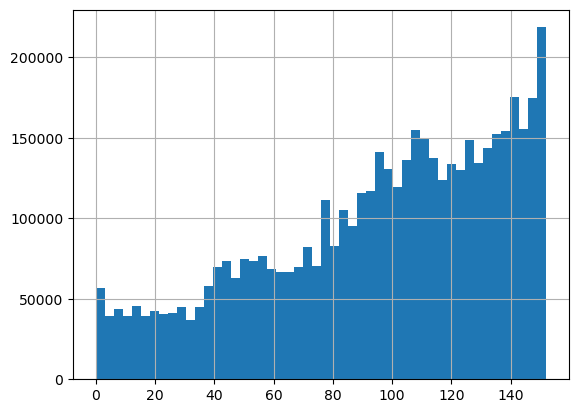

In [299]:
train.last_watch_dt.hist(bins=50)

In [300]:
train_stage_1 = train.loc[(train.last_watch_dt < 140)].copy()
valid_stage_1 = train.loc[(train.last_watch_dt >= 140)].copy()

In [310]:
train_stage_1.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,0,4485,98.0,1
1,952323,15997,0,7507,100.0,1
2,889459,11460,0,60,0.0,0
3,854016,11237,0,5381,98.0,1
4,307257,9132,0,5814,100.0,1




### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [470]:
train_df = train_stage_1.copy()
test_df = valid_stage_1.copy()

In [472]:
train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

n_users = 15000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

In [474]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, 
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)
joined = train_grouped.merge(test_grouped)

C:\Users\Asus\AppData\Local\Temp\ipykernel_14868\1383636529.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
C:\Users\Asus\AppData\Local\Temp\ipykernel_14868\1383636529.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


In [476]:
item2id = {k: v for v, k in enumerate(train_df.item_id.unique())}
user2id = {k:v for v, k in enumerate(train_df.user_id.unique())}

id2item = {k:v for v, k in item2id.items()}
id2user = {k:v for v, k in user2id.items()}

train_df['user_id'] = train_df.user_id.apply(lambda x: user2id[x])
train_df['item_id'] = train_df.item_id.apply(lambda x: item2id[x])

In [478]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (train_df['target'], (train_df['user_id'], train_df['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<15000x7352 sparse matrix of type '<class 'numpy.int64'>'
	with 165096 stored elements in COOrdinate format>

In [480]:
def fit_ease(X, reg_weight=2000):
    
    # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

w = fit_ease(matrix)

In [482]:
def get_preds(x, item2id, id2item):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id)) # n_items
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf # n_items

    items_final = np.argsort(-preds)
    decoded = [(id2item[t], preds[t]) for t in items_final][:50]
    
    return decoded
joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

,user_id,train_interactions,test_interactions,ease_preds
0,107,"[(2657, 79)]","[(12396, 152)]","[(10440, 0.02591642770968323), (15297, 0.01968..."
1,240,"[(14431, 93), (7834, 94), (15297, 123)]","[(9963, 149)]","[(10440, 0.1548667216526208), (3734, 0.0906654..."
2,299,"[(1154, 1), (9463, 40), (3208, 40), (12671, 40...","[(9728, 148), (12022, 148), (11697, 148), (376...","[(10440, 0.3121755537293569), (3734, 0.2142453..."
3,322,"[(14814, 94), (14242, 94), (12820, 94), (9728,...","[(603, 145), (9996, 147), (10440, 147), (7556,...","[(13865, 0.3971540515620066), (9728, 0.3966498..."
4,382,"[(1112, 89), (565, 129), (5411, 131), (14899, ...","[(12386, 146)]","[(16166, 0.040414480544048004), (12743, 0.0323..."


In [483]:
from tqdm import tqdm

new_ds = []
for row in tqdm(joined.itertuples()):
    for rec in row.ease_preds:
        new_ds.append((row.user_id, rec[0], rec[1], 1 if rec[0] in set(row.test_interactions[0]) else 0, len(row.train_interactions)))

new_ds = pd.DataFrame(new_ds, columns = ['user_id', 'item_id', 'score', 'label', 'num_intearctions'])
new_ds.label.mean()

15000it [00:00, 16488.08it/s]


0.007789333333333333

In [486]:
new_ds.head(5)

,user_id,item_id,score,label,num_intearctions
0,107,10440,0.025916,0,1
1,107,15297,0.019682,0,1
2,107,142,0.012051,0,1
3,107,13865,0.010033,0,1
4,107,3734,0.007298,0,1


In [488]:
from sklearn.metrics import roc_auc_score as auc

auc(new_ds['label'], new_ds['score'])

0.6951808629798306

In [624]:
from scipy.sparse.linalg import svds
def make_svd(interactions, n_singular_values: int = -1):
    S = np.zeros(interactions.shape)
    if n_singular_values == -1:
        k = 6
    else:
        k = n_singular_values

    U, s, V = svds(interactions, k=k)
    S[:len(s), :len(s)] = np.diag(s)
    U = U[: , :k]
    S = S[: k, : k]
    V = V[: k, :]

    return U, S, V

def make_svd_recommendations(interactions, n_singular_values: int = -1, top_k: int = 100):
    non_zero_indices = [np.nonzero(row)[0] for row in interactions.toarray()]
    U, S, V = make_svd(interactions, n_singular_values)
    score = U @ S @ V
    recommendations = np.argsort(score, axis=1)[:, ::-1]
    sorted_scores = np.take_along_axis(score, recommendations, axis=1)
    top_k_scores = sorted_scores[:, :top_k]
    filtered_recommendations = []
    for user_index, recs in enumerate(recommendations):
        # filtered_recs = [rec for rec in recs if rec not in non_zero_indices[user_index]]
        # filtered_recommendations.append(filtered_recs[:top_k])
        valid_mask = ~np.isin(recs, non_zero_indices[user_index])
        filtered_recs = recs[valid_mask][:top_k]
        filtered_recommendations.append(filtered_recs)

    return np.array(filtered_recommendations), top_k_scores

In [506]:
matrix2 = matrix.astype('float')

In [626]:
recs, score = make_svd_recommendations(matrix2, 10, 10)

In [ ]:
my_neural_network = # YOUR CODE HERE 


Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [424]:
train[train['item_id'] == 9728]

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
1575341,33059,9728,81,8,0.0,0
1597935,908029,9728,82,130,2.0,0
1621211,211186,9728,83,9620,100.0,1
1621229,1015539,9728,83,9394,100.0,1
1621279,1091750,9728,83,2154,32.0,0
...,...,...,...,...,...,...
4866625,60073,9728,152,6529,96.0,1
4866914,191654,9728,152,4526,66.0,1
4866924,432592,9728,152,3201,47.0,0
4866934,39443,9728,152,6345,93.0,1


In [420]:
valid_stage_1[valid_stage_1['user_id'] == 3]

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
4385971,3,2220,144,15588,100.0,1
4762703,3,12192,151,11499,15.0,0
4797330,3,15719,151,4933,97.0,1
4847526,3,6208,152,5310,100.0,1


In [396]:
valid_stage_1['last_watch_dt'].min()

140

In [384]:
users.head(2)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0


In [386]:
items.head(2)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,0.0,16.0,unknown,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,0.0,16.0,unknown,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."


In [390]:
bdf = new_ds.merge(users).merge(items[['content_type', 'release_year','genres', 'age_rating', 'item_id']])
bdf.head(2)

,user_id,item_id,score,label,num_intearctions,age,income,sex,kids_flg,content_type,release_year,genres,age_rating
0,9,10440,0.378976,0,4,age_25_34,income_20_40,Ж,0,series,2021.0,"триллеры, детективы",18.0
1,9,9728,0.196934,0,4,age_25_34,income_20_40,Ж,0,film,2021.0,"боевики, триллеры",18.0


In [400]:
for cat in ['age','income','sex','content_type']:
    bdf[cat] = bdf[cat].astype("category")

In [402]:
from sklearn.model_selection import train_test_split

train_bdf, test_bdf = train_test_split(bdf)

In [404]:
pos = train_bdf.loc[train_bdf.label==1].copy()
neg = train_bdf.loc[train_bdf.label==0].sample(pos.shape[0] * 4)

new_train = pd.concat([pos, neg])

In [ ]:
train_df_with_features = # YOUR CODE IS HERE
test_df_with_features = # YOUR CODE IS HERE


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [406]:
from lightgbm import LGBMClassifier, plot_importance

FEATURES = ['score', 'age','income','sex','content_type', 'release_year','num_intearctions']

 
fit_params={#"early_stopping_rounds": 35, 
           # "eval_metric": 'auc', 
           #"eval_set": [(test_df[FEATURES], test_df["label"])],
            #'eval_names': ['valid'],
            #'verbose': 5,
           }
clf = LGBMClassifier(max_depth=3, 
                     
                     #max_bin=30,
                     #boosting_type='dart',
                     random_state=0, 
                    # metric='None', 
                     n_estimators=100,
                     learning_rate=0.1,
                     n_jobs=10)
clf.fit(
    X=train_bdf[FEATURES],
    y=train_bdf["label"],
    **fit_params
)

[LightGBM] [Info] Number of positive: 34318, number of negative: 3378152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 3412470, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010057 -> initscore=-4.589414
[LightGBM] [Info] Start training from score -4.589414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(max_depth=3, n_jobs=10, random_state=0)

In [408]:
test_bdf['boosting_preds_new'] = clf.predict_proba(test_bdf[FEATURES])[:, 1]

In [410]:
test_bdf['boosting_preds'] = clf.predict_proba(test_bdf[FEATURES])[:, 1]

for model_name in ['score','boosting_preds']:
    print(model_name, ": ", auc(test_bdf['label'], test_bdf[model_name])) 

score :  0.6404690180318418
boosting_preds :  0.7497702824993933


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

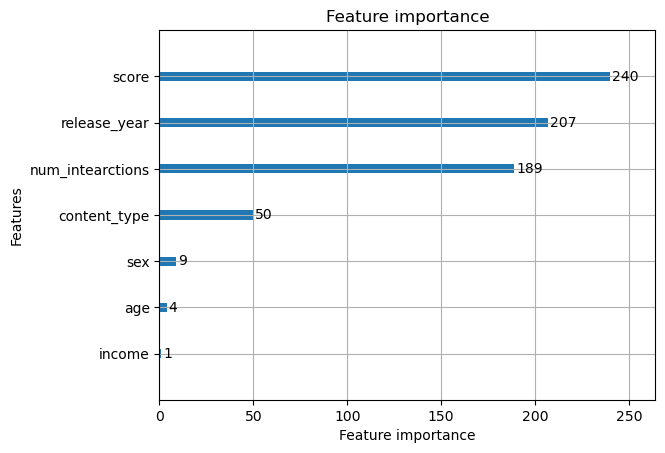

In [412]:
plot_importance(clf)


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [3]:
# YOUR CODE HERE